In [1]:
# Set seeds for repeatability.
from numpy.random import seed
seed(1)

# Import data processing modules.
import pandas as pd
import numpy as np

import wandb
from wandb.keras import WandbCallback

# Import Omphalos modules.
import generate_inputs as gi
import file_methods as fm
import my_metrics as mm
import omphalos_plotter as op
import attributes as attr
import labels as lbls

# Import data visualisation modules.
import seaborn as sns
import matplotlib.pyplot as plt

# Import sklearn. 
import sklearn.preprocessing as skp
import sklearn.gaussian_process as gp
import sklearn.gaussian_process.kernels as kernels

In [2]:
train_set = fm.unpickle('pure_train.pickle')
test_set = fm.unpickle('pure_test.pickle')

attributes_df = attr.initial_conditions(train_set, primary_species=True, mineral_vols=True)
attributes_df.drop(columns=['X', 'Y', 'Z', 'C5H7O2NSO4'], inplace=True)
labels_df = lbls.secondary_precip(train_set)
attributes_df.dtypes

/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:6390: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


CO2(aq)          float64
O2(aq)           float64
NH3(aq)          float64
Mg++             float64
Al+++            float64
Fe++             float64
Fe+++            float64
Ca++             float64
Ca44++           float64
K+               float64
SO4--            float64
S34O4--          float64
B(OH)3(aq)       float64
HPO4--           float64
H2S(aq)          float64
H2S34(aq)        float64
SiO2(aq)         float64
Na+              float64
Methane(aq)      float64
Cl-              float64
NO3-             float64
Formaldehyde     float64
FeS(am)          float64
FeS34(am)        float64
SiO2(am)         float64
Quartz           float64
Siderite         float64
Calcite          float64
Calcite44        float64
K-Feldspar       float64
Kaolinite        float64
C5H7O2NSO4(s)    float64
dtype: object

In [59]:
x = attributes_df.loc[:, ['CO2(aq)', 'Ca++', 'Calcite', 'Calcite44' ,'SO4--', 'Formaldehyde']].xs(1, level=1)
y = (labels_df.xs(5, level=1)['Calcite'] + labels_df.xs(5, level=1)['Calcite44']).drop(columns=['File Num'])

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, Normalizer, QuantileTransformer

scaler = QuantileTransformer(output_distribution='normal')

numeric_transformer = Pipeline(steps=[('scaler', scaler)])
#numeric_transformer = Pipeline(steps=[('scaler', scaler), ('normalizer', Normalizer())])

In [61]:
numeric_features = x.select_dtypes(include=['int64', 'float64']).columns
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [62]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer, Normalizer, quantile_transform
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel

#kernel = (Matern(length_scale=2, nu=2.5) + DotProduct()) * RBF(length_scale=1) + WhiteKernel()
#kernel = (Matern(length_scale=2, nu=2.5) + (DotProduct())) * RBF(length_scale=1) + WhiteKernel()
#kernel = (Matern(length_scale=0.00001, nu=2.5) + WhiteKernel())
kernel = RBF(length_scale=[0.001], length_scale_bounds=(1e-10, 1))

#regressor = TransformedTargetRegressor(regressor=GaussianProcessRegressor(kernel, n_restarts_optimizer=1, alpha=1e-3), transformer=QuantileTransformer(output_distribution='normal'))
regressor = GaussianProcessRegressor(kernel, n_restarts_optimizer=0, alpha=1e-7, random_state=1)

rf = Pipeline(steps=[('regressor', regressor)])

In [ ]:
rf.fit(x_train, y_train)

In [58]:
samples = 5000
x_pred = np.ones((samples, 5))
x_pred[:,0] = x.to_numpy()[:,0].mean()
x_pred[:,2] = x.to_numpy()[:,2].mean()
x_pred[:,3] = x.to_numpy()[:,3].mean()
x_pred[:,4] = x.to_numpy()[:,4].mean()
x_pred[:,1] = np.linspace(0.00, 0.12, samples)

In [133]:
x_train.mean()

CO2(aq)      0.001976
Ca++         0.010284
Ca44++       0.000218
Calcite      0.089553
Calcite44    0.001899
dtype: float64

In [134]:
test = x_train[(x_train['Ca44++'] <= 0.00032) & (x_train['Ca44++'] >= 0.00012) & (x_train['CO2(aq)'] >= 0.0009) & (x_train['CO2(aq)'] <= 0.0029) 
               & (x_train['Calcite'] >= 0.08) & (x_train['Calcite'] <= 0.10) & (x_train['Calcite44'] >= 0.0009) & (x_train['Calcite44'] <= 0.0029)]
#test[test['Ca44++'] >= 0.000220]
test

,CO2(aq),Ca++,Ca44++,Calcite,Calcite44
File Num,,,,,
8167,0.001915,0.006097,0.000129,0.090633,0.001921
289,0.002104,0.008422,0.000179,0.097557,0.002068
6183,0.001101,0.006107,0.000130,0.088883,0.001884
9977,0.002188,0.014873,0.000316,0.094809,0.002010
4781,0.001462,0.006115,0.000130,0.083111,0.001762
...,...,...,...,...,...
7399,0.002480,0.011856,0.000252,0.084183,0.001785
5731,0.000952,0.012225,0.000259,0.097294,0.002063
3303,0.001059,0.011491,0.000244,0.090725,0.001923


In [37]:
y_pred, sigmas = rf.predict(x_pred, return_std=True)

/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


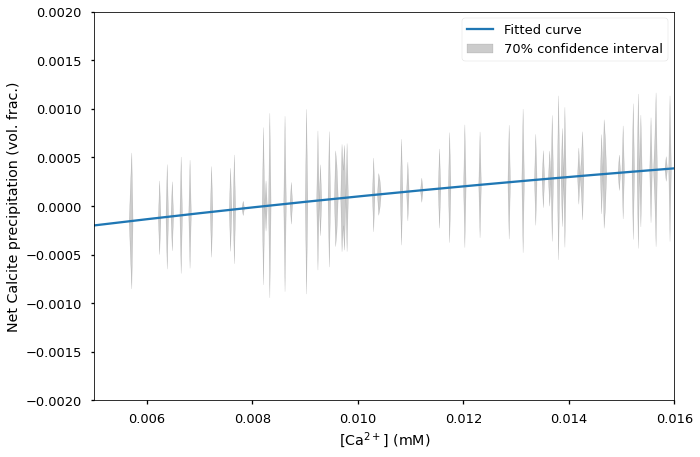

In [40]:
#f = plt.errorbar(x_pred[:,1], y_pred, yerr=sigmas, capsize=0, ecolor='#01153e10', label='Fitted curve & 70% confidence interval')
plt.style.use('seaborn-talk')
f, ax = plt.subplots(1,1)
ax.plot(x_pred[:,1], y_pred, label='Fitted curve')
ax.fill_between(x_pred[:,1], y_pred - sigmas, y_pred + sigmas, alpha=0.2, color='k', label='70% confidence interval')
#ax.scatter(test['Ca++'].to_numpy(), y_train[test.index], marker="+", color='#980002', label='Modelled Net Precipitation')
ax.set_xlabel('[Ca$^{2+}$] (mM)')
ax.set_ylabel('Net Calcite precipitation (vol. frac.)')
plt.legend()
plt.savefig('fit.png', dpi=300, bbox_inches='tight')
ax.set_xlim(0.005, 0.016)
ax.set_ylim(-0.002, 0.002)
plt.savefig('fit_zoom.png', dpi=300, bbox_inches='tight')


In [52]:
print(rf.score(x_train, y_train))
print(rf.score(x_test, y_test))

0.9426201848851562
0.9277000141707513


In [11]:
rf['regressor'].__dict__

{'kernel': RBF(length_scale=0.001),
 'alpha': 1e-07,
 'optimizer': 'fmin_l_bfgs_b',
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'copy_X_train': True,
 'random_state': 1,
 'kernel_': RBF(length_scale=0.554),
 '_rng': RandomState(MT19937) at 0x166DA1440,
 'n_features_in_': 5,
 '_y_train_mean': array([0.]),
 '_y_train_std': 1,
 'X_train_': array([[4.59824425e-04, 1.72747016e-02, 3.66683958e-04, 1.57669867e-02,
         3.34262259e-04],
        [1.34502482e-03, 3.83411090e-03, 8.13853110e-05, 2.57021356e-01,
         5.44888765e-03],
        [8.92403782e-04, 7.46380318e-03, 1.58431500e-04, 1.95311704e-02,
         4.14063463e-04],
        ...,
        [4.90039231e-03, 1.12515478e-04, 2.38832611e-06, 6.20667082e-02,
         1.31582264e-03],
        [8.15282159e-03, 2.33075354e-02, 4.94740780e-04, 1.03700746e-01,
         2.19846990e-03],
        [3.09804183e-04, 1.14817573e-03, 2.43719187e-05, 4.64898812e-02,
         9.85591793e-04]]),
 'y_train_': array([ 0.00022938, -0.00026214,

In [273]:
y_pred = rf.predict(x_test)
percent = (100 * ((y_pred - y_test) / y_test))
percent.describe()

count      2000.000000
mean         66.590606
std        5588.584868
min      -68619.016994
25%         -38.870749
50%         -12.146856
75%          16.924261
max      232886.909670
dtype: float64

(-1000.0, 1000.0)

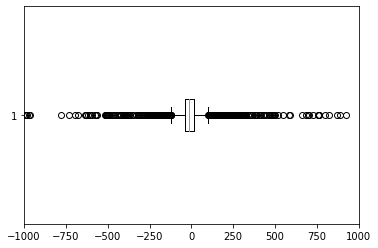

In [281]:
f = plt.boxplot(percent, vert=False)
plt.xlim(-1000,1000)

In [221]:
# from sklearn.preprocessing import power_transform

v = rf[:1].fit_transform(x_train)
w = np.array(y_train)
u = quantile_transform(w.reshape(-1,1), output_distribution='normal')